# Evolution of patents in the world

In [1]:
import pandas as pd

Patent authority where the application was filled

In [76]:
data = pd.read_csv("./../data/patents_per_country.csv", sep=";",
                  names=["country_short", "year", "n_patents"])[1:]

In [77]:
data.head()

,country_short,year,n_patents
1,DK,1967,3305.0
2,US,1939,44222.0
3,BG,1989,1360.0
4,VN,1999,1.0
5,SU,1911,6.0


In [78]:
country_codes = pd.read_csv("../data/country_codes.csv", sep=";")

In [79]:
country_codes.head()

,country,country_short
0,AFGHANISTAN,AF
1,ALBANIA,AL
2,ALGERIA,DZ
3,ANDORRA,AD
4,ANGOLA,AO


In [80]:
data = data.merge(country_codes, on='country_short')
data.year = pd.to_numeric(data.year)
data.n_patents = pd.to_numeric(data.n_patents)

In [81]:
data.head()

,country_short,year,n_patents,country
0,DK,1967,3305.0,DENMARK
1,DK,1961,2981.0,DENMARK
2,DK,1964,3243.0,DENMARK
3,DK,1970,2914.0,DENMARK
4,DK,1993,8453.0,DENMARK


In [82]:
pd.DataFrame(data.groupby("country").n_patents.sum()).sort_values(by="n_patents", axis=0, ascending=False)

,n_patents
country,
JAPAN,15316682.0
UNITED STATES,14948130.0
GERMANY,5972070.0
CHINA,5968600.0
UNITED KINGDOM,3515530.0
CANADA,3234817.0
FRANCE,3166705.0
"KOREA, REPUBLIC OF",2992035.0
AUSTRALIA,1765441.0


In [101]:
sums = data.groupby(["country", "year"]).sum()

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

In [107]:
def plot_per_country(ctry):
    df = pd.DataFrame(sums.loc[(ctry, )])
    df = df[df.index <= 2015]
    plt.plot(df.index, df.n_patents)

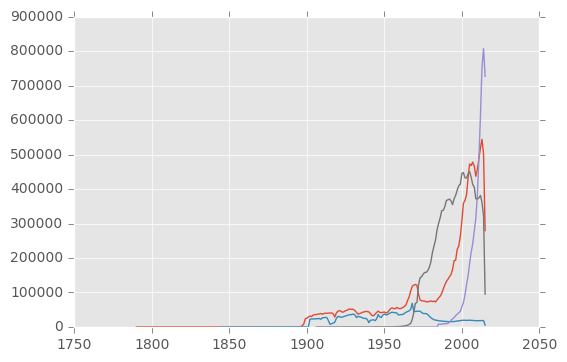

In [118]:
plt.style.use("")
plot_per_country("UNITED STATES")
plot_per_country("FRANCE")
plot_per_country("CHINA")
plot_per_country("JAPAN")

In [95]:
swiss = pd.DataFrame(test.loc[("SWITZERLAND", )])

In [99]:
swiss = swiss[swiss.index < 2017]

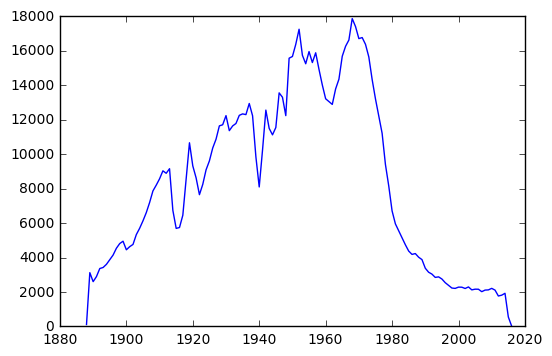

In [100]:
plt.plot(swiss.index, swiss.n_patents)